In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)
 
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn2

from src.features import build_features

sns.set_theme(palette="pastel")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option("display.max_columns", None)

COLUMNAS_GRD = [
    "RUT",
    "SEXO",
    # "EDAD_CANT",
    "PREVI",
    "BENEF",
    "NOM_HOPI_P",
    "FECHA_INGRESO",
    "FECHA_EGRESO",
    "ANO_EGR",
    "DIAS_ESTAD",
    "DIAG1",
    "DIAG2",
    "DIAG3",
    "INTERV_Q",
    "COD_FONASA",
    "INTERV_Q_PPAL",
    "INTERV_Q_2",
    "INTERV_Q_3",
    "T_DIAG1",
    "T_DIAG2",
    "T_DIAG3",
    "PROCED",
    "PROCED_PPAL",
    "PROCED_2",
    "PROCED_3",
]

COLUMNA_GRD_INTERNO = [
    "rut",
    "sexo_cod",
    "prevision_cod",
    "hospital_de_procedencia_cod",
    "fecha_ingreso",
    "fecha_de_egreso",
    "ano_de_egreso",
    "estancias_totales",
    "diag_01_principal_cod",
    "diag_01_principal_des",
    "diag_02_secundario_cod",
    "diag_02_secundario_des",
    "diag_03_secundario_cod",
    "diag_03_secundario_des",
    "proced_01_principal_cod",
    "proced_01_principal_des",
    "1ra_intervencion_cirujano",
    "especialidad_medica_de_la_intervencion_des",
]

In [3]:
RUTA_SABANAS = "../data/processed/grd_sabanas.csv"
COLUMNAS_FECHA_SABANAS = ["FECHA_INGRESO", "FECHA_EGRESO"]

RUTA_GRD_INTERNO = "../data/processed/grd_interno.csv"
COLUMNAS_FECHA_GRD_INT = ["fecha_ingreso", "fecha_de_egreso"]

RUTA_PABELLON = "../data/external/datos_limpios_pabellon.csv"

# Leer y formatear datos de GRD
df_grd_sabanas = build_features.cargar_datos_grd(RUTA_SABANAS, columnas=COLUMNAS_GRD)
df_grd_sabanas = build_features.formatear_columnas_fecha(df_grd_sabanas, COLUMNAS_FECHA_SABANAS)

df_grd_interno = build_features.cargar_datos_grd(RUTA_GRD_INTERNO, columnas=COLUMNA_GRD_INTERNO)
df_grd_interno = build_features.formatear_columnas_fecha(df_grd_interno, COLUMNAS_FECHA_GRD_INT)
df_grd_interno = df_grd_interno.reset_index(names="id_egreso")

# Leer y formatear datos de operaciones quirúrgicas
df_pabellon = pd.read_csv(RUTA_PABELLON, encoding="latin-1", sep=";")
df_pabellon["fecha"] = pd.to_datetime(df_pabellon["fecha"])
df_pabellon["duracion"] = pd.to_timedelta(df_pabellon["duracion"])

# Limpiar datos de operaciones quirúrgicas
df_pabellon_limpio = build_features.limpiar_datos_operaciones_quirurgicas(df_pabellon)

/Users/javierrojas/Documents/SSMO/EPH - INT/21-grd-interno/src/features/build_features.py:6: DtypeWarning: Columns (80,156) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, usecols=columnas)


Una vez que se han limpiado todas las bases de datos, se procedera a unir GRD y Pabellon.

In [4]:
# Fusionar GRD con datos de operaciones quirúrgicas
grd_sabanas_y_pabellon = build_features.fusionar_grd_con_operaciones_quirurgicas(
    df_grd_sabanas, df_pabellon_limpio, "RUT", COLUMNAS_FECHA_SABANAS[0], COLUMNAS_FECHA_SABANAS[1]
)
grd_interno_y_pabellon = build_features.fusionar_grd_con_operaciones_quirurgicas(
    df_grd_interno, df_pabellon_limpio, "rut", COLUMNAS_FECHA_GRD_INT[0], COLUMNAS_FECHA_GRD_INT[1]
)

In [5]:
# Calcular estadísticas resumidas
resumen_duraciones = build_features.calcular_estadisticas_resumidas(
    grd_sabanas_y_pabellon, ["ANO_EGR", "DIAG1"], "duracion"
)
resumen_grd_interno_duraciones_por_operacion = build_features.calcular_estadisticas_resumidas(
    grd_interno_y_pabellon,
    ["ano_de_egreso", "diag_01_principal_cod", "proced_01_principal_des"],
    "duracion",
).sort_values(["ano_de_egreso", "diag_01_principal_cod", "count"], ascending=[True, True, False])

resumen_duraciones_por_diagnostico_total = build_features.calcular_estadisticas_resumidas(
    grd_interno_y_pabellon, ["ano_de_egreso", "diag_01_principal_cod"], "duracion"
)

# Preparar dataframes para exportar a Excel
a_guardar = {
    "por_diagnostico": resumen_duraciones_por_diagnostico_total,
    "por_diagnostico_e_int_q": resumen_grd_interno_duraciones_por_operacion,
}

# Guardar dataframes en Excel
build_features.guardar_en_excel(
    a_guardar, "../data/interim/duraciones_de_int_q_por_diagnostico.xlsx"
)

In [6]:
df_grd_interno.groupby("ano_de_egreso")["especialidad_medica_de_la_intervencion_des"].count()

ano_de_egreso
2015    1783
2016    1338
2017    1372
2018    1608
2019    1636
2020    1002
2021    1474
2022    1639
Name: especialidad_medica_de_la_intervencion_des, dtype: int64

In [7]:
grd_interno_y_pabellon.groupby("ano_de_egreso")["id_egreso"].nunique()

ano_de_egreso
2015    1344
2016    1364
2017    1402
2018    1591
2019    1601
2020     581
2021     510
2022     566
Name: id_egreso, dtype: int64

In [8]:
RUTS_GRD_INTERNO = set(df_grd_interno["rut"].unique())
RUTS_GRD_SABANAS = set(df_grd_sabanas["RUT"].unique())

ruts_solo_en_grd_interno = RUTS_GRD_INTERNO - RUTS_GRD_SABANAS
ruts_solo_en_grd_sabanas = RUTS_GRD_SABANAS - RUTS_GRD_INTERNO

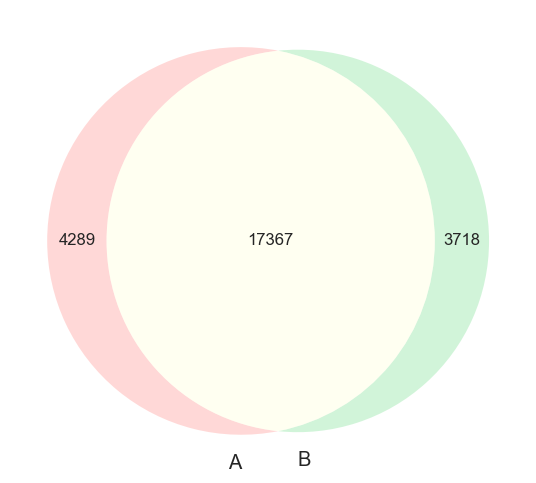

In [9]:
venn2([RUTS_GRD_INTERNO, RUTS_GRD_SABANAS])